In [1]:
import requests
import requests
import pandas as pd
import datetime
from json import JSONEncoder
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import  StandardScaler
import matplotlib.pyplot as plt

In [2]:
class DateTimeEncoder(JSONEncoder):
        #Override the default method
        def default(self, obj):
            if isinstance(obj, (datetime.date, datetime.datetime)):
                return obj.isoformat()

In [67]:
def lpfaPrediction(objectId,attributeId):
   #query = {'id':objectId,'attributes':attributeId,'startDate':startDate,'endDate':endDate}
   query = {'id':objectId,'attributes':attributeId,'startDate':'2021-09-15 00:00:00','endDate':'2021-09-17 00:00:00'}
   query = DateTimeEncoder().encode(query)
   query = eval(query)
   print(query)
   response = requests.get('http://54.206.42.58:8006/api/historicalData/getObjectAttributeHistoricalData', params=query)
      
   data = response.json()
   exportedData = data["data"]["ObjectData"]
   if objectId in exportedData:
      newExportedData = exportedData[objectId][attributeId]["timeSeriesData"]
      required_data = pd.DataFrame(newExportedData, columns=["measurementtimestamp", "value"])
      required_data.set_index('measurementtimestamp', inplace = True)
      df = required_data["value"].astype('int')
      
   else:
      required_data = []
      #reading the variable of interest in a series 
      df = pd.Series(required_data)

In [62]:
'''
Delete this later
'''

def get_data(id,attri):
  #query = {'id':id,'attributes':attri,'startDate':'2021-03-01 00:00:00','endDate':'2021-03-05 23:59:59'}
  query = {'id':id,'attributes':attri,'startDate':'2021-09-15 00:00:00','endDate':'2021-09-19 23:59:59'}
  query = DateTimeEncoder().encode(query)
  query = eval(query)
  response = requests.get('http://54.206.42.58:8006/api/historicalData/getObjectAttributeHistoricalData', params=query)
      
  data = response.json()
  exportedData = data["data"]["ObjectData"][id][attri]["timeSeriesData"]

  required_data = pd.DataFrame(exportedData, columns=["measurementtimestamp", "value"])
  required_data.set_index('measurementtimestamp', inplace = True)
  required_data["value"] = required_data["value"].astype('float')
  #required_data.columns = [id + '_' + 'AP']
  return required_data


def resample_to_day( df ):
  temp = df.reset_index()
  temp['measurementtimestamp']  = pd.to_datetime(temp['measurementtimestamp'],utc=True)
  #temp = temp.resample('60T', on='measurementtimestamp').mean().dropna(how='all')
  return temp 

we will use 
1. Ambient Temparature Celsius.
2. Avg in-plane irradiance.
3. Back-of-module temparature 
4. Irradiance Plane-of-Array (W/m^2)

In [19]:
def bring_weather_data():
    weather_data = []
    for each in ['Ambient Temperature Celsius' ,'AVG in-plane irradiance' ,'Back-of-Module Temperature (deg C)','Irradiance Plane-of-Array (W/m^2)']:
        weather_data.append(get_data('WP_SF_MVPS4.WS1' ,each ))
    pd.concat(weather_data,axis =1 )
    return pd.concat(weather_data,axis =1 )

def resample_to_hour( df ):
  temp = df.reset_index()
  temp['measurementtimestamp']  = pd.to_datetime(temp['measurementtimestamp'],utc=True)
  temp = temp.resample('60T', on='measurementtimestamp').mean().dropna(how='all')
  return temp 


def Isolation_forest(df):
    temp = df
    print(len(temp))
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(df)
    data = pd.DataFrame(np_scaled)
    # train isolation forest
    outliers_threshold = 0.05
    model =  IsolationForest(contamination=outliers_threshold )
    model.fit(data)
    temp['Label'] = list(pd.Series(model.predict(data)))
    df['Label'] = df['Label'].map( {1: 0, -1: 1} )
    fig, ax = plt.subplots(figsize=(30,6))
    a = temp[temp['Label'] == -1] #anomaly
    ax.plot( pd.to_numeric(temp.index), temp['Active Power'], color='blue', label = 'Normal')
    ax.scatter( pd.to_numeric(a.index), a['Active Power'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();
    return temp

def get_data(id,attri):
    ''' 
    Edit this if your running a cron Job 
    queryTimeDiff = datetime.timedelta(minutes=90)
    endDate = datetime.datetime.now()
    startDate = datetime.datetime.now() - queryTimeDiff
    '''
    #query = {'id':id,'attributes':attri,'startDate':'2021-03-01 00:00:00','endDate':'2021-03-05 23:59:59'}
    query = {'id':id,'attributes':attri,'startDate':'2021-09-15 00:00:00','endDate':'2021-09-19 23:59:59'}
    query = DateTimeEncoder().encode(query)
    query = eval(query)
    response = requests.get('http://54.206.42.58:8006/api/historicalData/getObjectAttributeHistoricalData', params=query)

    data = response.json()
    exportedData = data["data"]["ObjectData"][id][attri]["timeSeriesData"]

    required_data = pd.DataFrame(exportedData, columns=["measurementtimestamp", "value"])
    required_data.set_index('measurementtimestamp', inplace = True)
    required_data["value"] = required_data["value"].astype('float')
    #required_data.columns = [id + '_' + 'AP']
    return required_data

def Isolation_forest_prediction( objectId,attributeId ):
    variable_of_intererst = get_data(objectId,attributeId)
    main_df = bring_weather_data()
    main_df[attributeId] =variable_of_intererst
    #print(main_df)
    main_df.columns = ['Ambient Temperature Celsius' ,'AVG in-plane irradiance' ,'Back-of-Module Temperature (deg C)','Irradiance Plane-of-Array (W/m^2)' , attributeId]
    print(main_df.isna().sum())
    temp = main_df.copy( deep=True )
    hourly_df = resample_to_hour(main_df)
    Anamoly_df =  Isolation_forest(hourly_df)
    results =  Anamoly_df.reset_index().to_dict(orient = 'records')
    finalData = []
    counter = 0
    for data in results:
        tempData = {
        "objectid": objectId,
        "attributeserviceid":"IFA_"+attributeId,
        "measurementtimestamp": data['measurementtimestamp'],
        "value" : data[attributeId],
        "customData": {
        "value": data['Label'],
        "Ambient Temperature Celsius": data['Ambient Temperature Celsius'],
        "AVG in-plane irradiance": data['AVG in-plane irradiance'],
        "Back-of-Module Temperature (deg C)": data['Back-of-Module Temperature (deg C)'],
        "Irradiance Plane-of-Array (W/m^2)": data['Irradiance Plane-of-Array (W/m^2)'],
        }
        }
        finalData.append(tempData)
    return finalData 

    

In [20]:
returned  =  Isolation_forest_prediction( 'WP_SF_MVPS4.PM1','Active Power')

Ambient Temperature Celsius            58
AVG in-plane irradiance               693
Back-of-Module Temperature (deg C)     27
Irradiance Plane-of-Array (W/m^2)      27
Active Power                            1
dtype: int64
88


In [21]:
returned

[{'objectid': 'WP_SF_MVPS4.PM1',
  'attributeserviceid': 'IFA_Active Power',
  'measurementtimestamp': Timestamp('2021-09-15 00:00:00+0000', tz='UTC'),
  'value': 116.06079959869385,
  'customData': {'value': 1,
   'Ambient Temperature Celsius': 12.763636328957297,
   'AVG in-plane irradiance': 595.25,
   'Back-of-Module Temperature (deg C)': 19.41818176616322,
   'Irradiance Plane-of-Array (W/m^2)': 733.3636363636364}},
 {'objectid': 'WP_SF_MVPS4.PM1',
  'attributeserviceid': 'IFA_Active Power',
  'measurementtimestamp': Timestamp('2021-09-15 01:00:00+0000', tz='UTC'),
  'value': 127.16140174865723,
  'customData': {'value': 1,
   'Ambient Temperature Celsius': 13.300000111262003,
   'AVG in-plane irradiance': 535.5,
   'Back-of-Module Temperature (deg C)': 16.99999992052714,
   'Irradiance Plane-of-Array (W/m^2)': 603.1666666666666}},
 {'objectid': 'WP_SF_MVPS4.PM1',
  'attributeserviceid': 'IFA_Active Power',
  'measurementtimestamp': Timestamp('2021-09-15 02:00:00+0000', tz='UTC'),

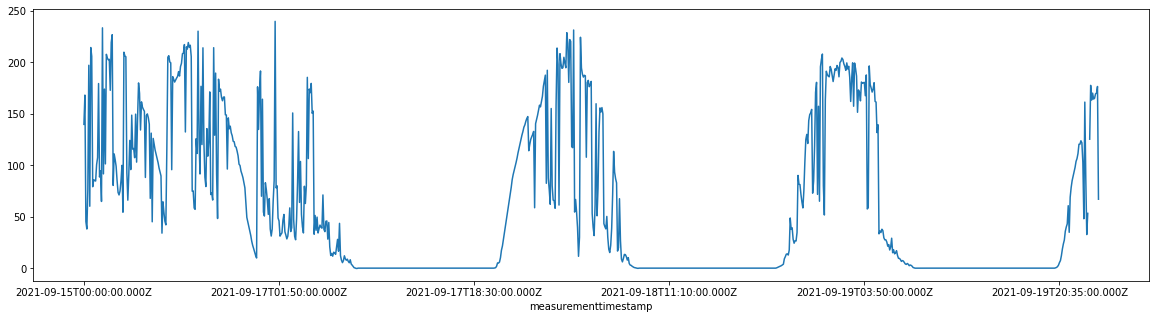

In [14]:
plt.figure( figsize = (20,5) )
returned['Active Power'].plot()

In [ ]:
returned.columns = pd.MultiIndex.from_product([df.columns, ['C']])

In [7]:
returned

,Ambient Temperature Celsius,AVG in-plane irradiance,Back-of-Module Temperature (deg C),Irradiance Plane-of-Array (W/m^2),Active Power,Label
measurementtimestamp,,,,,,
2021-09-15 00:00:00+00:00,12.763636,595.25,19.418182,733.363636,116.060800,1
2021-09-15 01:00:00+00:00,13.300000,535.50,17.000000,603.166667,127.161402,1
2021-09-15 02:00:00+00:00,13.933333,769.75,18.850000,856.916667,148.349000,1
2021-09-15 03:00:00+00:00,13.563637,548.75,16.591667,600.166667,114.923355,1
2021-09-15 04:00:00+00:00,13.483333,855.00,18.109091,955.545455,135.495319,1
...,...,...,...,...,...,...
2021-09-19 19:00:00+00:00,8.575000,0.00,7.116667,0.000000,0.000000,1
2021-09-19 20:00:00+00:00,8.233333,16.50,7.241667,47.083333,6.012178,1
2021-09-19 21:00:00+00:00,9.208333,581.75,10.227273,597.363636,62.801930,-1


In [91]:
returned.reset_index().to_dict(orient = 'records')

[{'measurementtimestamp': Timestamp('2021-09-15 00:00:00+0000', tz='UTC'),
  'Ambient Temperature Celsius': 12.763636328957297,
  'AVG in-plane irradiance': 595.25,
  'Back-of-Module Temperature (deg C)': 19.41818176616322,
  'Irradiance Plane-of-Array (W/m^2)': 733.3636363636364,
  'Active Power': 116.06079959869385,
  'Label': 1},
 {'measurementtimestamp': Timestamp('2021-09-15 01:00:00+0000', tz='UTC'),
  'Ambient Temperature Celsius': 13.300000111262003,
  'AVG in-plane irradiance': 535.5,
  'Back-of-Module Temperature (deg C)': 16.99999992052714,
  'Irradiance Plane-of-Array (W/m^2)': 603.1666666666666,
  'Active Power': 127.16140174865723,
  'Label': 1},
 {'measurementtimestamp': Timestamp('2021-09-15 02:00:00+0000', tz='UTC'),
  'Ambient Temperature Celsius': 13.933333237965902,
  'AVG in-plane irradiance': 769.75,
  'Back-of-Module Temperature (deg C)': 18.85000006357829,
  'Irradiance Plane-of-Array (W/m^2)': 856.9166666666666,
  'Active Power': 148.34899965922037,
  'Label': 

In [8]:
import requests
ap  = get_data('WP_SF_MVPS4.PM1' ,'Active Power' )


Ir = get_data('WP_SF_MVPS4.WS1' ,'Irradiance Global (W/m^2)' )


rain = get_data('WP_SF_MVPS4.WS1' ,'Rainfall (mm)' )


df = pd.concat( [ ap , Ir , rain  ] , axis  = 1  )



df.columns = [  'activepower' , 'irradiance' ,'rainfall' ]
#df.columns = [  'activepower' , 'irradiance'  ]
temp = df.copy( deep=True )
#df = resample_to_day(df)
#display(df.head(25))
temp.reset_index().head(25).dtypes

measurementtimestamp     object
activepower             float64
irradiance              float64
rainfall                float64
dtype: object